# Group Project #2

# PART 1

## EDA

### Read Data

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error

data = pd.read_csv('coca_cola_earnings.csv', sep=";",decimal=",")
data.head()
y = data.iloc[:,1]

### Organize Data

In [16]:
#Convert dates
#data['anntime'] =  pd.to_datetime(data['anntime'], format='%Y%m%d')
#data.set_index('anntime', inplace = True)
#y = data.copy()

## Model Testing

### Plot Series, ACF and PACF

In [17]:
#Log si es necesario
log = 'no' # Change here only accepts yes or no


##############################
if log == 'yes': # do not change
    y = np.log(y)

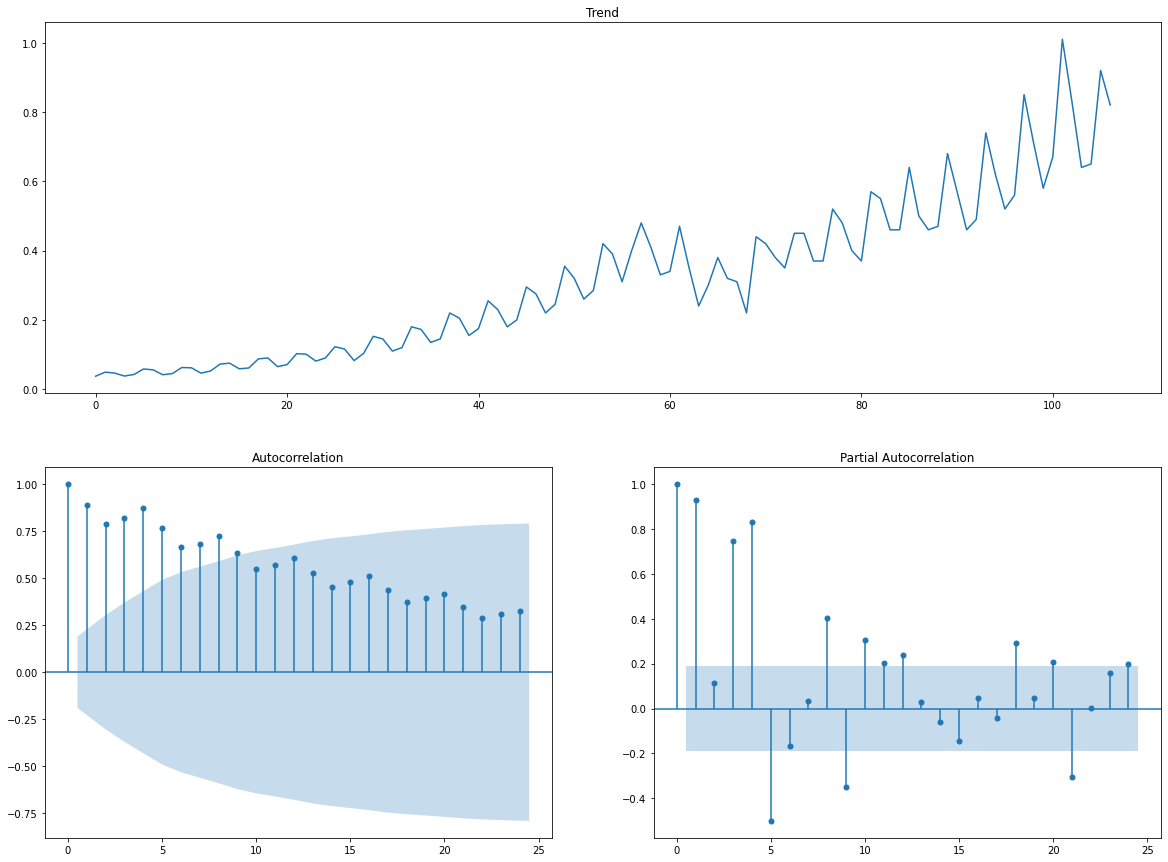

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

nlags = 24 # play with this parameter

# ValueError: Can only compute partial correlations for lags up to 50% of the sample size.



fig, ax = plt.subplot_mosaic([['y', 'y'],
                               ['acf'     , 'pacf'    ]], figsize = (20,15) )
                             
ax['y'].plot(y)
ax['y'].set_title('Trend')
acf =plot_acf(y, lags = nlags,ax = ax['acf'])
pacf = plot_pacf(y, method="ols",lags = nlags, ax=ax['pacf'])

### Checking Stationary and differences

In [19]:
#!pip install pmdarima

In [20]:
import statsmodels as sm
import pmdarima
from pmdarima.arima import ndiffs, nsdiffs


# Ho: the process is not stationary. We need, at least, a unit root
# H1: the process is stationary. We have to check different models (lags)

adf_test = sm.tsa.stattools.adfuller(y,maxlag=10) 
# print("adf_test", adf_test) # first output "The test statistic", second output "p-value"
#print("ADF test for the original series")
#print("Statistic Value:" , adf_test[0])
if adf_test[1] < 0.05:
    mean_stationary = 'Stationary in the mean'
else:
    mean_stationary = 'Not stationary in the mean'
        

print(f'ADF Test p-value: {adf_test[1]:.3}, {mean_stationary}')

# Tests
s = 4
d = ndiffs(y, alpha = 0.05, test='adf')  # regular differences?
D = nsdiffs(y, m = s, test='ocsb') # # seasonal differences?

print("Regular differences: ", d)
print('Seasonal differences:', D)

ADF Test p-value: 0.995, Not stationary in the mean
Regular differences:  1
Seasonal differences: 1


## Model Creation

                                     SARIMAX Results                                     
Dep. Variable:                             value   No. Observations:                  107
Model:             SARIMAX(1, 1, 0)x(2, 1, 0, 4)   Log Likelihood                 193.870
Date:                           Mon, 07 Mar 2022   AIC                           -379.739
Time:                                   16:09:13   BIC                           -369.239
Sample:                                        0   HQIC                          -375.488
                                           - 107                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1762      0.063     -2.814      0.005      -0.299      -0.053
ar.S.L4       -0.4501      0.095     -4.726

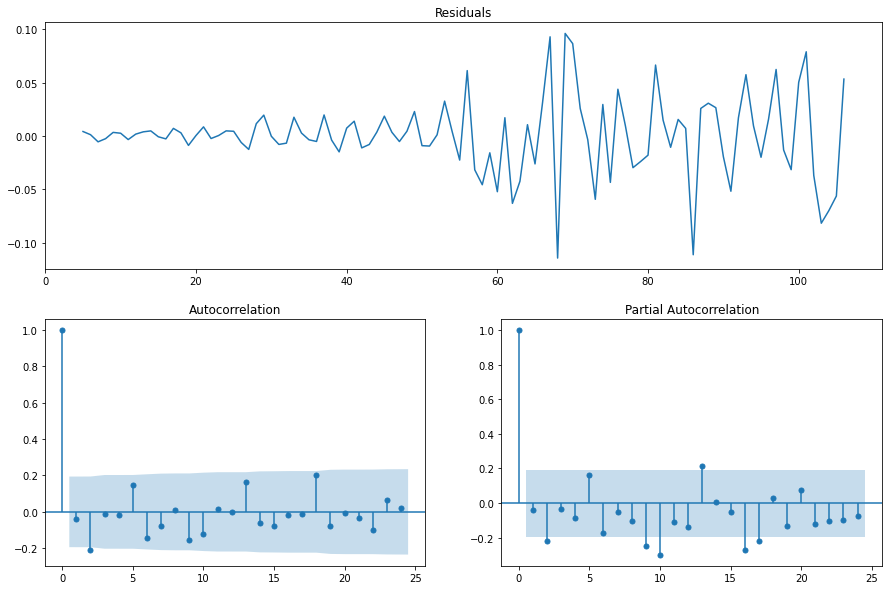

In [21]:
#Seasonality
s = 4
fit = SARIMAX(endog = y, order = (1,1,0), seasonal_order = (2,1,0,s)).fit()
print(fit.summary())
residuos = fit.resid[(s+1):]
 
nlags=24

fig, ax = plt.subplot_mosaic([['residuals', 'residuals'],
                               ['acf'     , 'pacf'    ]], figsize = (15,10) )
                             
ax['residuals'].plot(residuos)
ax['residuals'].set_title('Residuals')
acf =plot_acf(residuos, lags = nlags,ax = ax['acf'])
pacf = plot_pacf(residuos, method="ols",lags = nlags, ax=ax['pacf'])


### Model Verification

Ljung-Box p-value: 0.484, Residuals are NOT autocorrelated
Shapiro p-value: 0.000313, Not Normal


C:\Users\jlbet\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)
C:\Users\jlbet\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


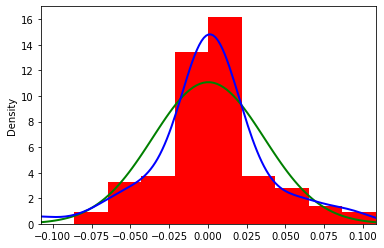

In [22]:
# Box test
import statsmodels.api as sm
box_test = sm.stats.acorr_ljungbox(residuos, lags=[36])

if box_test[1][0] < 0.05:
    correlated = 'Residuals are autocorrelated'
else:
    correlated = 'Residuals are NOT autocorrelated'

#print("Ljung-Box: Statistic value", box_test[0], "p-value", box_test[1]) 

print(f'Ljung-Box p-value: {box_test[1][0]:.3}, {correlated}')

from scipy.stats import shapiro
import seaborn as sns
import scipy.stats as st

# Normalitresiduos test

saphiro = shapiro(residuos)

if saphiro[1] < 0.05:
    normal = 'Not Normal'
else:
    normal = 'Normal'
#print("Shapido: Statistic value", saphiro[0],"p-value",saphiro[1]) # first output "The test statistic", second output "p-value"
print(f'Shapiro p-value: {saphiro[1]:.3}, {normal}')

mean = np.mean(residuos)
std = np.std(residuos)
mu = np.mean(residuos)
sigma = np.std(residuos)
x = np.linspace(mu -3*sigma, mu +3*sigma, 100)
pdf = st.norm.pdf(x, mu, sigma)
ax = plt.plot(x, pdf, lw = 2, color = "g")
ax = plt.hist(residuos,density=True, range = (mean - 3*std, mean + 3*std), color = "r")
ax = sns.distplot(residuos, hist = False, kde = True,
                 kde_kws = {'linewidth': 2}, color = "blue")
ax.set_xlim(mean - 3*std, mean + 3*std)

plt.show()

## Model Prediction

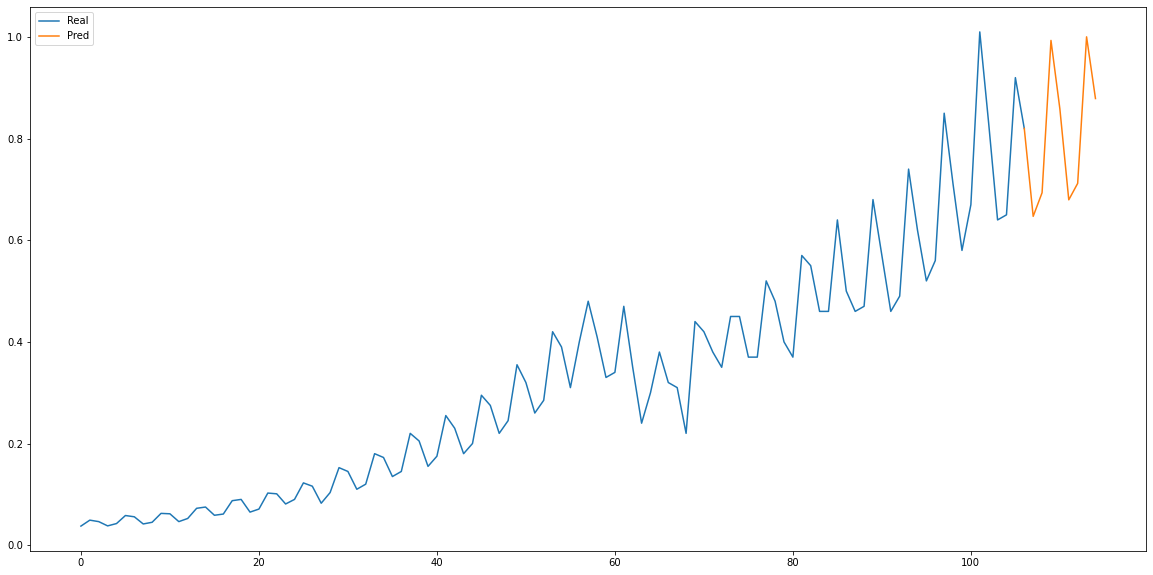

In [23]:
# Pintamos las siguientes 8 predicciones
y_pred = fit.forecast(steps = 8)

# Ponemos el último índice real
y_pred.loc[len(y)-1] = y[len(y)-1]

# Reseteamos los índices, ordenamos por índice y volvemos a poner el índice como índice de la Serie.
y_pred = y_pred.reset_index().sort_values(by = 'index').set_index('index')

#Convertor de nuevo los logs
if log == 'yes': # do not change
    y_pred = np.exp(y_pred)
    y = np.exp(y)


# Las predicciones dan 0, el modelo arriba que está con todos los parámetros en 0 salvo
# el 's' no sé si dará algún problema en Python y no lo haga como en R o me he equivocado en otro sitio
# print(y_pred)
plt.figure(figsize = (20,10))
plt.plot(y, label = 'Real')
plt.plot(y_pred, label = 'Pred')
plt.legend()
plt.show()

# Part 2

In [24]:
#Keep the models that better work
s =4
sarimax =[ {'y_log': 'yes', 'Sarimax_regular':(0,1,1),'Sarimax_seasonal':(0,1,1,s) },
          {'y_log': 'no', 'Sarimax_regular':(0,1,1),'Sarimax_seasonal':(0,1,1,s) },
          {'y_log': 'yes', 'Sarimax_regular':(1,1,0),'Sarimax_seasonal':(1,1,0,s) },
          {'y_log': 'no', 'Sarimax_regular':(1,1,0),'Sarimax_seasonal':(1,1,0,s) },
          {'y_log': 'yes', 'Sarimax_regular':(1,1,0),'Sarimax_seasonal':(2,1,0,s)},
           {'y_log': 'yes', 'Sarimax_regular':(1,1,1),'Sarimax_seasonal':(2,1,0,s)},
         ]
          

### Estimation

In [25]:
def plot_estimations(data,dic_sarima,steps_num,way = 'expand'):
    fig, ax = plt.subplots(len(sarimax),1, figsize = (20,15))

    for sarima, splt in zip(dic_sarima, ax):
        pred = pd.Series(index = data.index[-24:],dtype='float')

       # print(sarima)
        for num in range(24,0,-steps_num):
           # print(num)
        #Take values
            y = data.iloc[:,1]

            #Take log if necessary
            if sarima['y_log']=='yes':
                y = np.log(y)
            
            if way =='rolling':
                y_train = y[24-num:-num]
            else:
                y_train = y[:-num]
            
            
            fit = SARIMAX(endog = y_train, order = sarima['Sarimax_regular'], seasonal_order = sarima['Sarimax_seasonal']).fit()
            #print('b')
            y_pred = fit.forecast(steps = steps_num)
            #print('a')
                #redo log
            if sarima['y_log']=='yes':
                y =np.exp(y)
                y_pred = np.exp(y_pred)
                y_train = np.exp(y_train)
            pred[y_pred.index] = (y_pred.values[0:steps_num])   
        splt.plot(y[:-23], color ='blue',label = 'train')
        splt.plot(y[-24:], color ='blue', label= 'test', linestyle = ':')
        splt.plot(pred, color = 'red', linestyle = ":", label = 'predicted')
        splt.set_title(f"log:{sarima['y_log']}, Regular: {sarima['Sarimax_regular']}, Seasonal: {sarima['Sarimax_seasonal']}",
                      fontsize= 18)
        score = mean_absolute_percentage_error(y[-24:],pred)
        splt.text(20,0.8,f'MAPE: {score:.3%}',fontsize = 'xx-large')
        splt.legend()
    fig.tight_layout()

### Entire Estimation

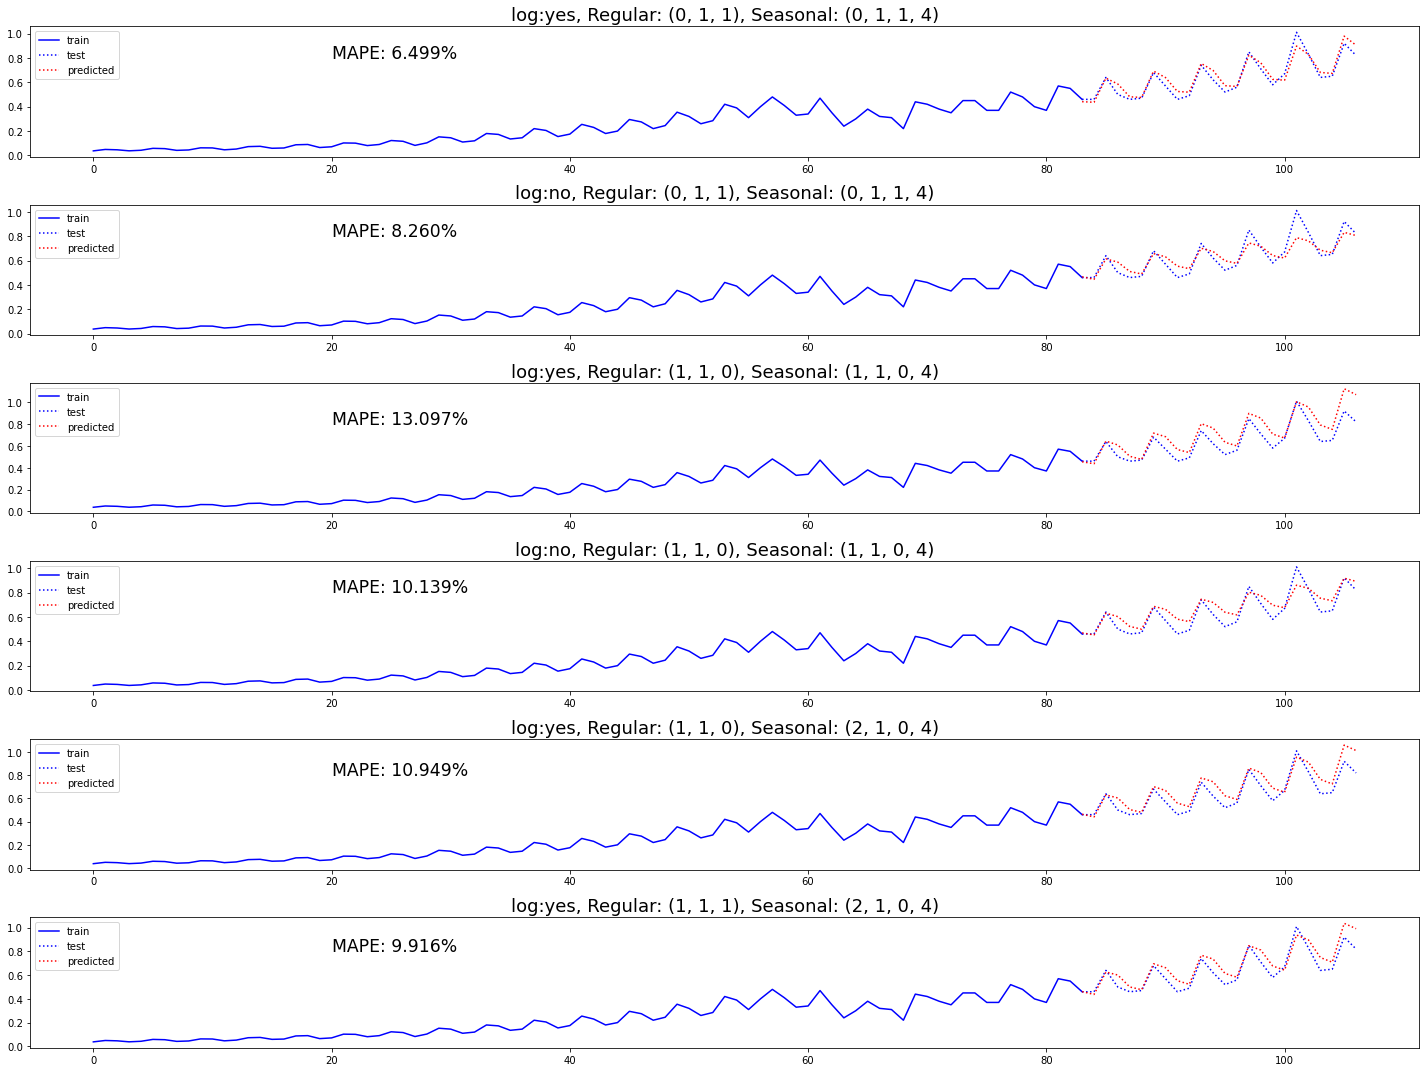

In [26]:
plot_estimations(data= data,dic_sarima= sarimax,steps_num= 24, way = 'expand')

### Estimation Year

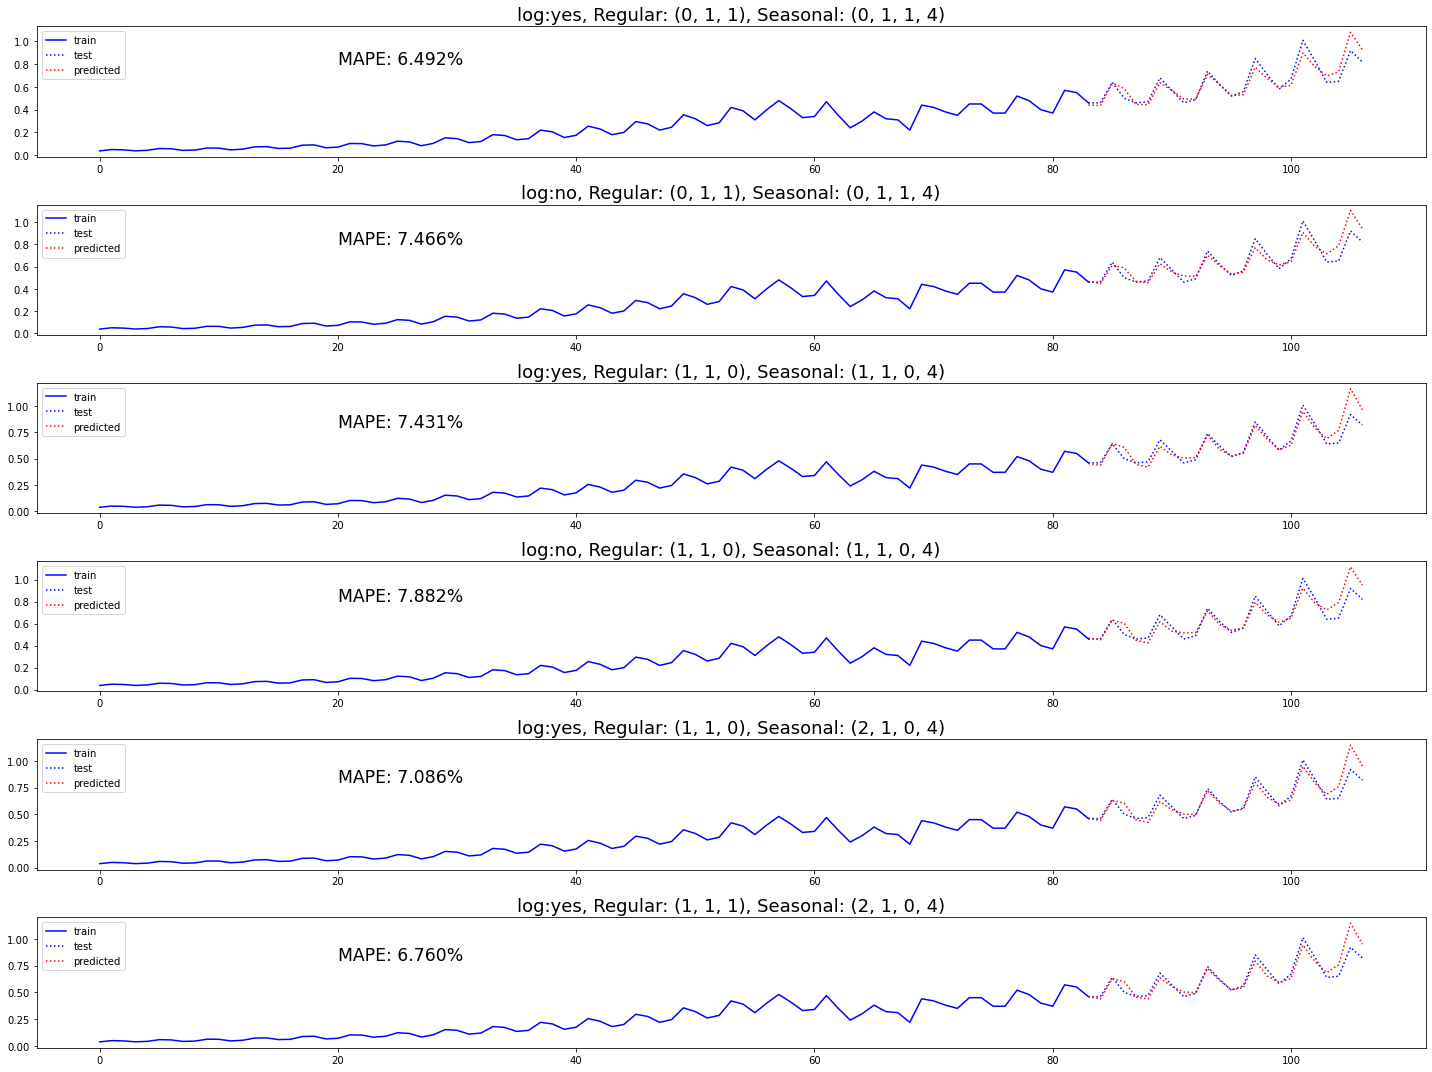

In [27]:
#Expand
plot_estimations(data= data,dic_sarima= sarimax,steps_num= 4, way = 'expand')

### Estimation Quarter

C:\Users\jlbet\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\jlbet\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


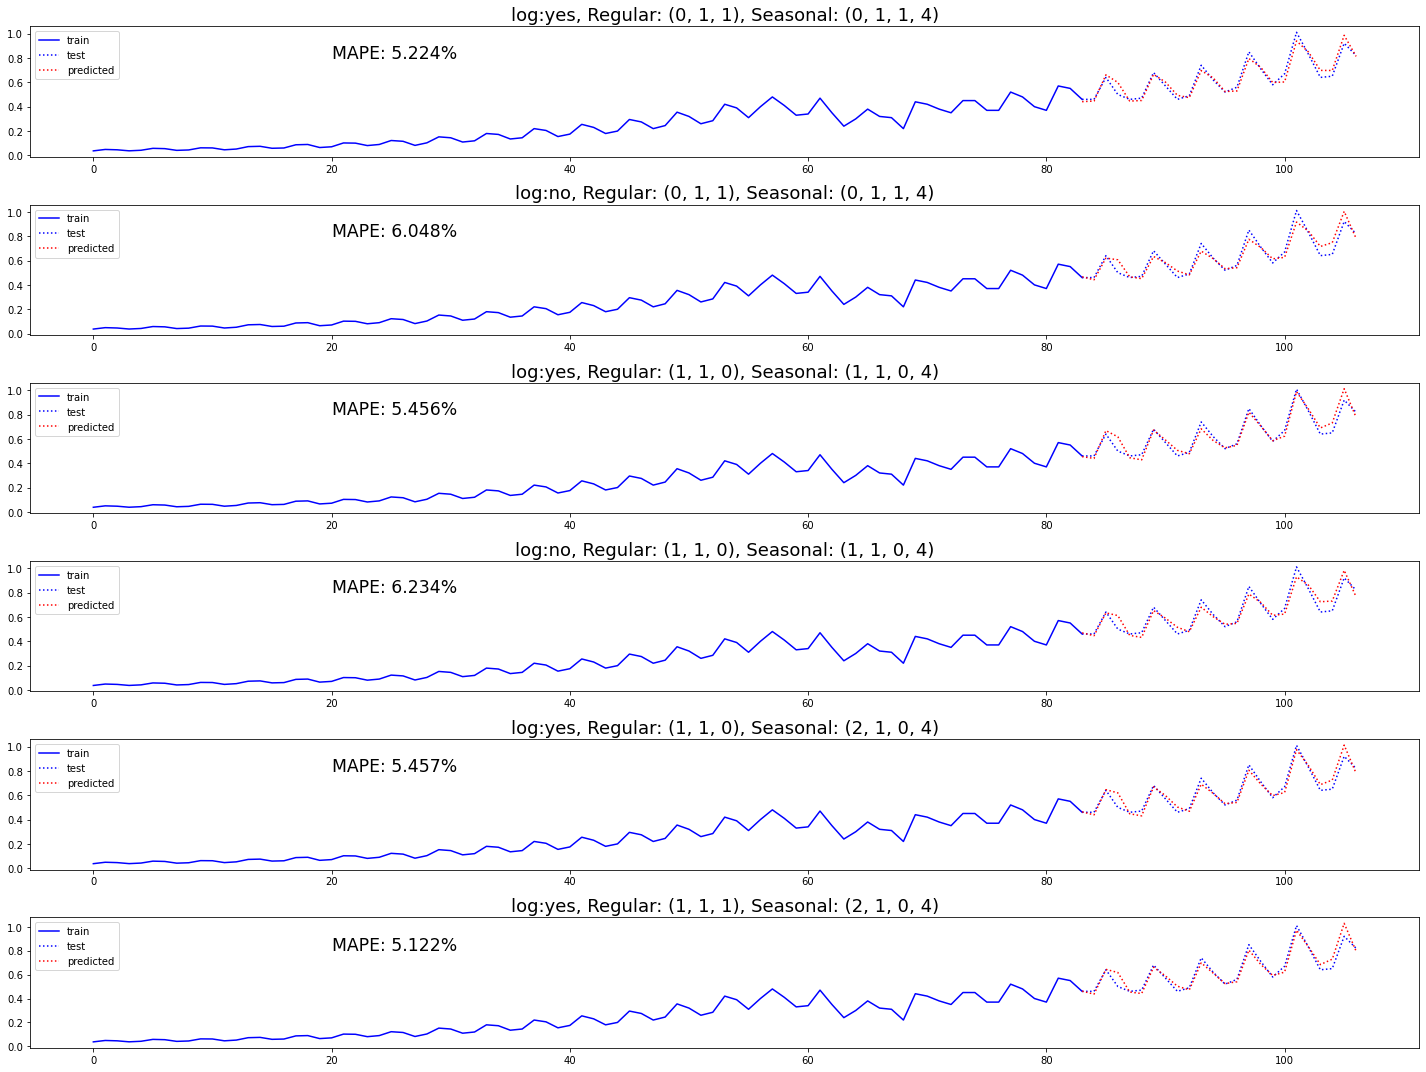

In [28]:
#Expand
plot_estimations(data= data,dic_sarima= sarimax,steps_num= 1, way = 'expand')